# Background

Climate Change is one of the biggest threats to our planet, so I decided to predict the average land temperature in the future. I chose three periods which I based on in creating my models. The reason behind creating three models is the different temperature growth rates throughout nearly 3 centuries. Data in the 18th and 19th centuries are also more distracted than nowadays. It can be a consequence of worse measure technology.

# Content:
1. [Setup](#1)
2. [EDA](#2)
    * [Decomposition](#2.1)
3. [Moving Average](#3)
    * [Create a Trend Feature](#3.1)
4. [Linear Regression:](#4)
    * [1750 - 2015](#4.1)
    * [1850 - 2015](#4.2)
    * [1950 - 2015](#4.3)
5. [ARIMA Model:](#5)

# <a id="1">Setup</a>

In [1]:
!pip install pmdarima

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from learntools.time_series.style import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv


In [2]:
temperatures = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv')
temperatures.index = pd.to_datetime(temperatures.dt, format='%Y-%d-%m')
temperatures = temperatures.drop(columns=['dt'])

# <a id="2">EDA</a>

In [3]:
temperatures.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-01-02,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-01-03,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-01-04,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-01-05,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
max(temperatures.index)

Timestamp('2015-01-12 00:00:00')

In [5]:
temperatures.dtypes

LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

In [6]:
temperatures.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


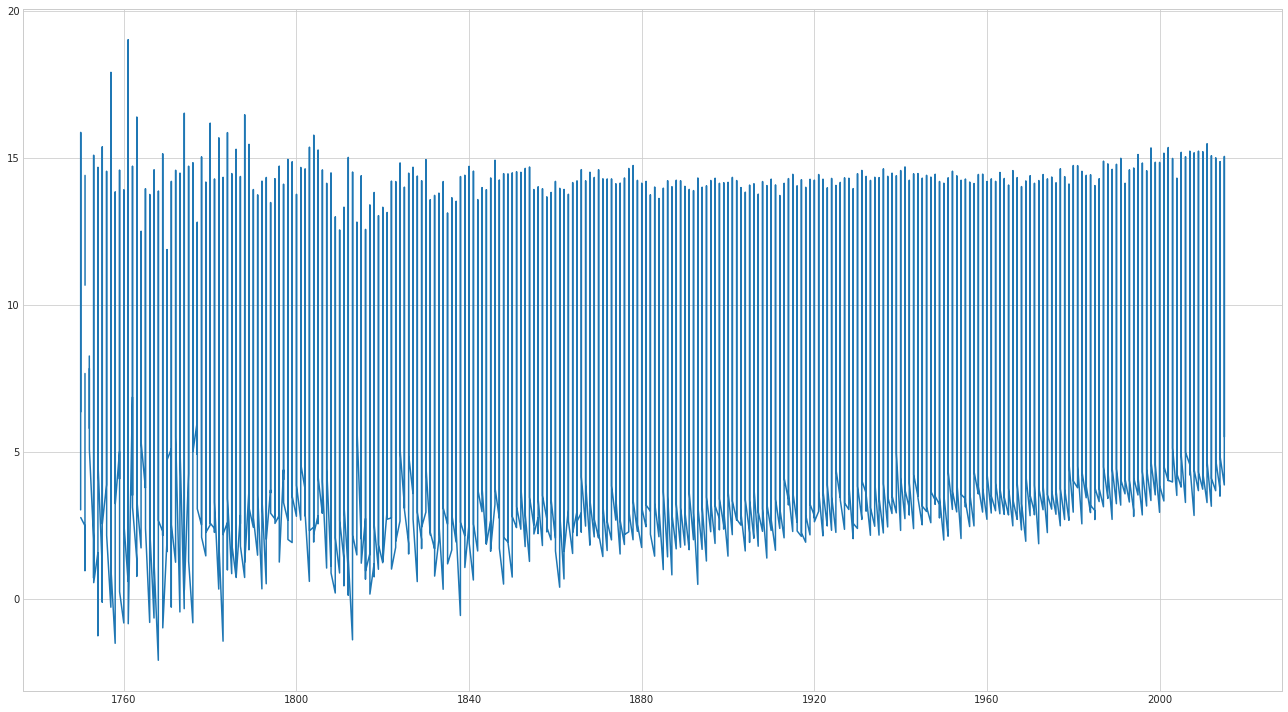

In [7]:
plt.figure(figsize=(18,10))
plt.plot(temperatures['LandAverageTemperature'])
plt.show()

In [8]:
temperatures['Year'] = temperatures.index.year

In [9]:
yearly_data = temperatures['LandAverageTemperature'].asfreq('Y')
yearly_mean = yearly_data.resample('Y').mean()

In [10]:
df = temperatures.resample('Y').mean()

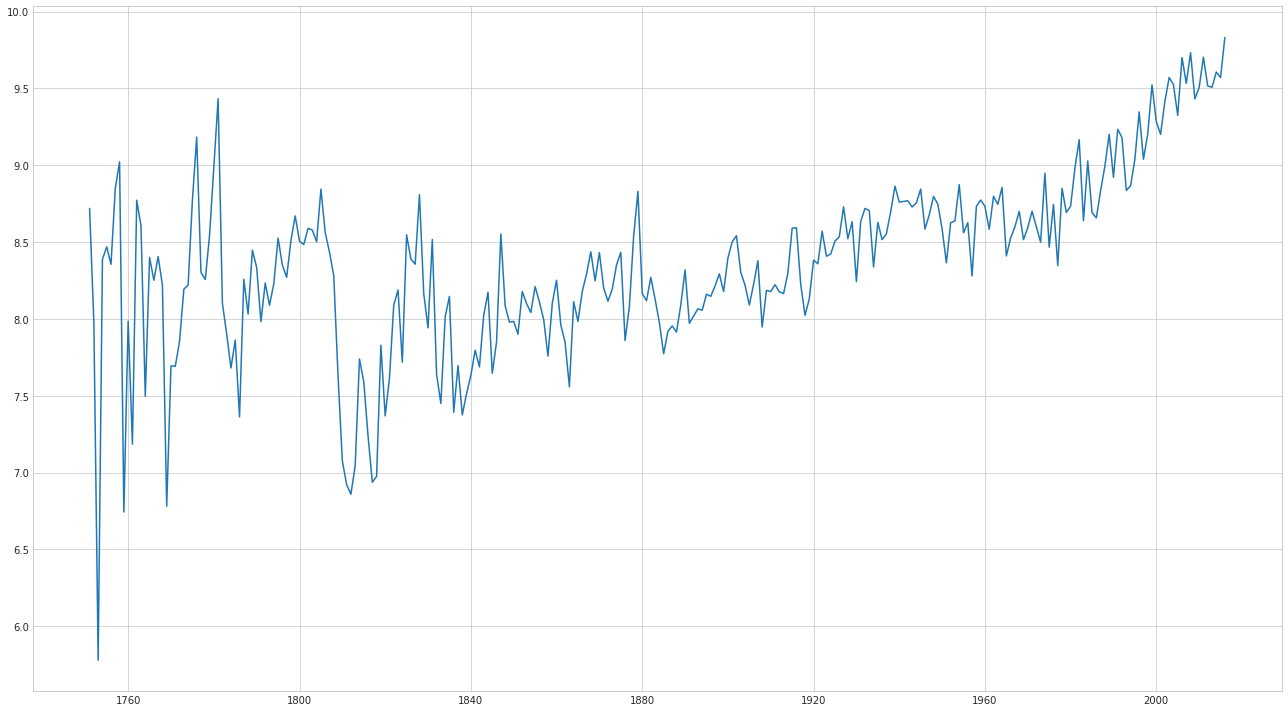

In [11]:
plt.figure(figsize=(18,10))
plt.plot(df['LandAverageTemperature'])
plt.show()

## <a id="2.1">Decomposition</a>

In [12]:
temperatures = temperatures.resample('D').mean().ffill()

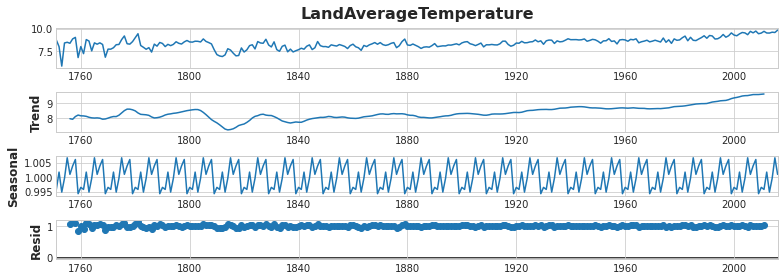

In [13]:
decomposition = seasonal_decompose(df['LandAverageTemperature'], model='multiplicative', period=10)
fig = decomposition.plot()

# <a id="3">Moving Average</a>

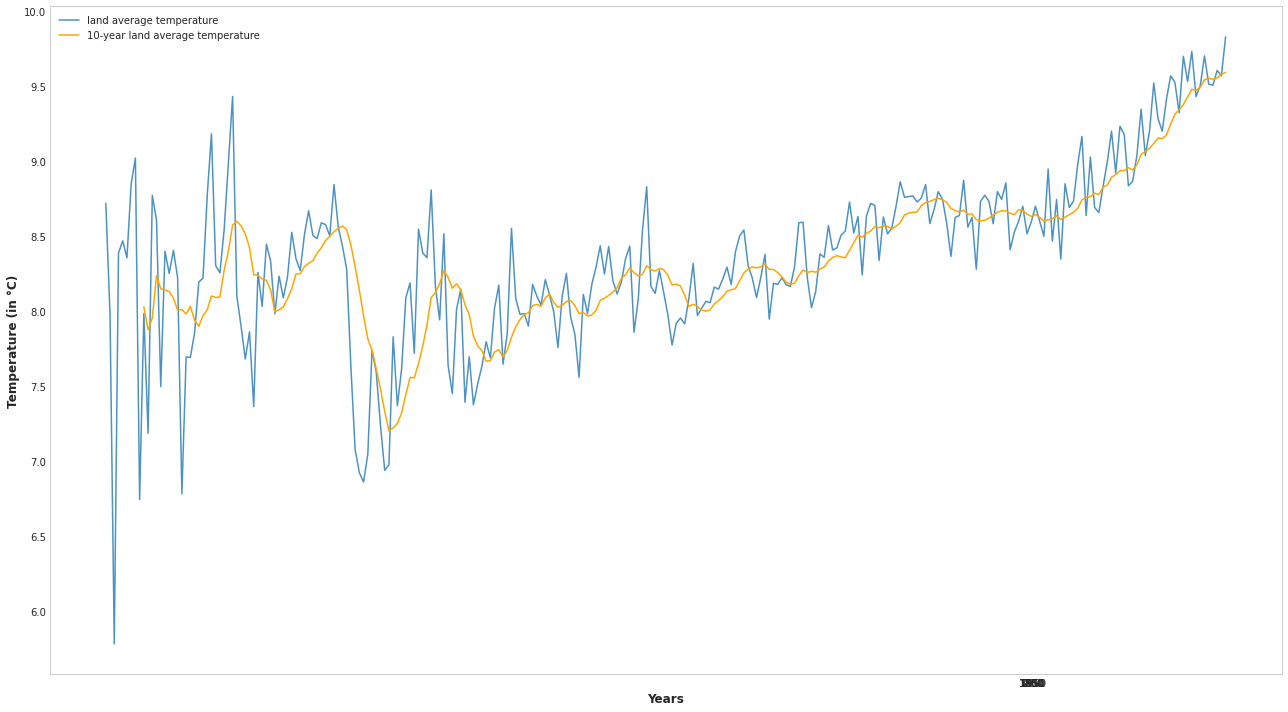

<Figure size 792x288 with 0 Axes>

In [14]:
temperature_px = df['LandAverageTemperature']
df['10'] = temperature_px.rolling(window=10).mean()

plt.figure(figsize=(18,10))
ax = plt.subplot()
ax.plot(df['LandAverageTemperature'], alpha=0.8, label='land average temperature')
ax.plot(df['10'], color="orange", label='10-year land average temperature')
ax.set_xticks([0,50,100,150,200,250])
ax.set_xticklabels([1750,1800,1850,1900,1950,2000])
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
plt.grid()
plt.legend()
plt.show()
plt.clf()

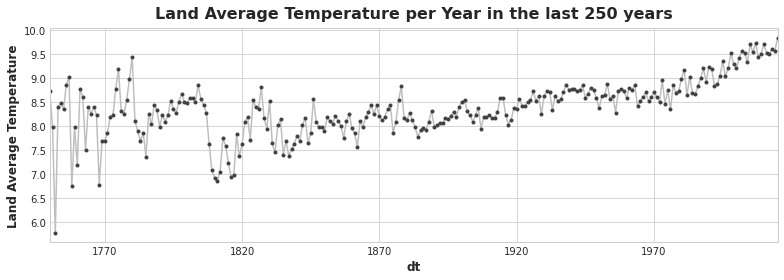

In [15]:
ax = df['LandAverageTemperature'].plot(**plot_params)
ax.set(title="Land Average Temperature per Year in the last 250 years", ylabel="Land Average Temperature")
plt.show()

## <a id="3.1">Create a Trend Feature</a>

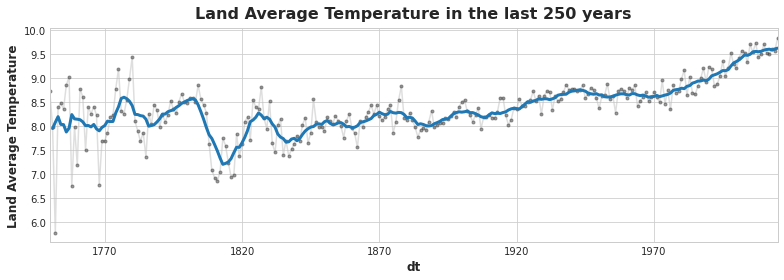

In [16]:
trend = df['LandAverageTemperature'].rolling(
    window=10,
    center=True,
    min_periods=6,
).mean()

ax = df['LandAverageTemperature'].plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.set(title="Land Average Temperature in the last 250 years", ylabel="Land Average Temperature")
plt.show()

In [17]:
from statsmodels.tsa.deterministic import DeterministicProcess

average_temperature = df['LandAverageTemperature']
y = average_temperature.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

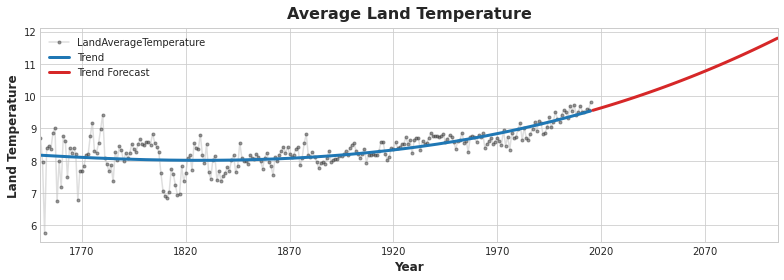

In [18]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Land Temperature", ylabel="Land Temperature")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
plt.xlabel('Year')
ax.legend();

# <a id="4">Linear Regression</a>

## <a id="4.1">Data from 1750 - 2015</a>

In [19]:
corr, p = pearsonr(df.index.year, df['LandAverageTemperature'])
print('Pearson correlation of Year and Land Average Temperature: ' + str(corr))

Pearson correlation of Year and Land Average Temperature: 0.6223364823755806


Strong positive correlation

In [20]:
lr = LinearRegression()

X = df.index.year
y = df['LandAverageTemperature']

X = X.values.reshape(-1,1)

lr.fit(X, y)

y_pred = lr.predict(X)

years = pd.DataFrame(X)

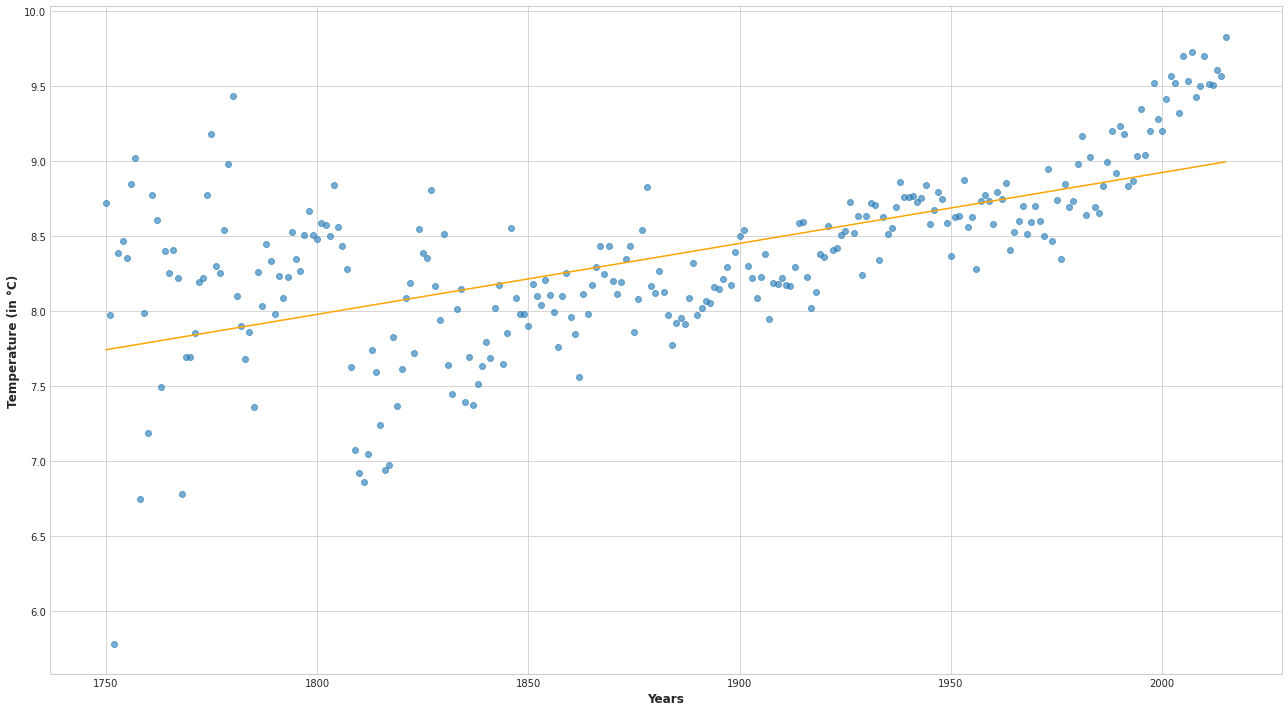

<Figure size 792x288 with 0 Axes>

In [21]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange")
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
plt.show()
plt.clf()

In [22]:
print(lr.coef_)
print(10 * lr.coef_)

[0.00473169]
[0.04731692]


In [23]:
print(lr.predict(np.array([2030, 2050]).reshape(-1,1)))

[9.06726169 9.16189553]


#### Interpretation

Every year, the average land temperature increases by an average of 0.0047 °C. Every ten years, the average land temperature increases by an average of 0.0473 °C.
The average land temperature in 2030 will be 9.067 °C and in 2050 9.162 °C.

## <a id="4.2">Data from 1850 - 2015</a>

In [24]:
corr, p = pearsonr(df[df.index.year >= 1850].index.year, df[df.index.year >= 1850]['LandAverageTemperature'])
print('Pearson correlation of Year and Land Average Temperature: ' + str(corr))

Pearson correlation of Year and Land Average Temperature: 0.865681931251089


Very strong positive correlation

In [25]:
lr = LinearRegression()

X = df[df.index.year >= 1850].index.year
y = df[df.index.year >= 1850]['LandAverageTemperature']

X = X.values.reshape(-1,1)

lr.fit(X, y)

y_pred = lr.predict(X)

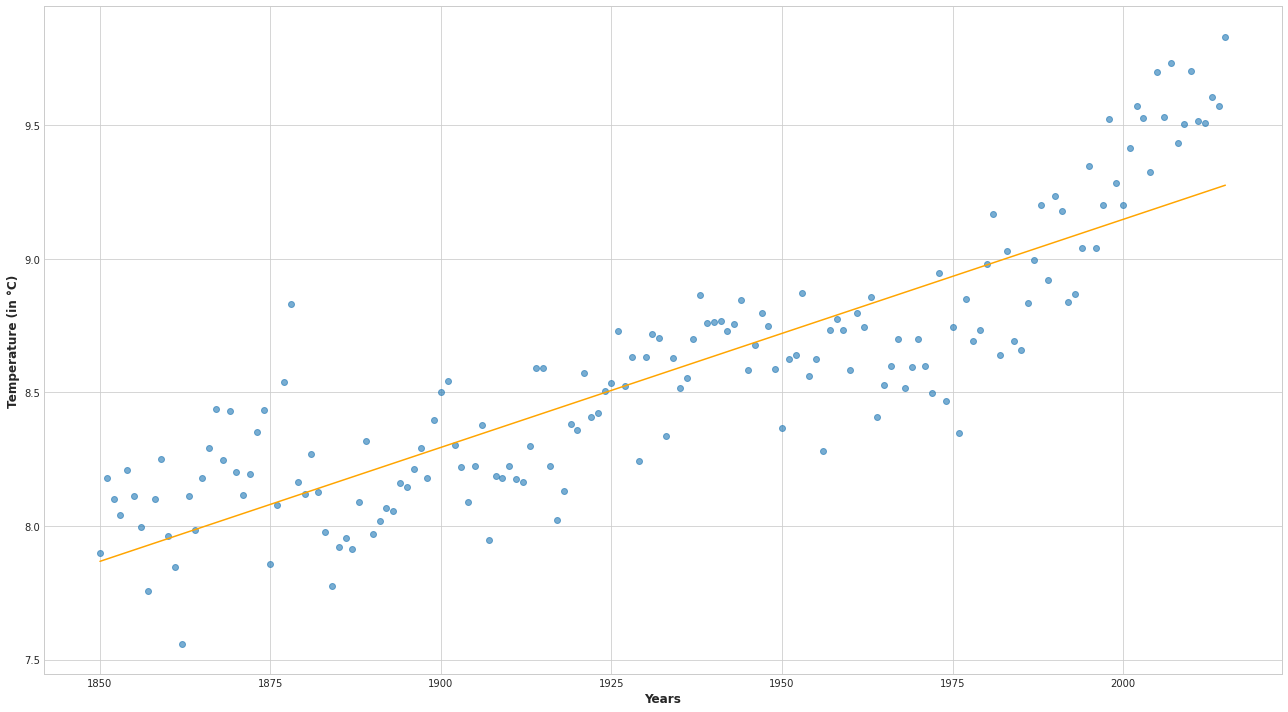

<Figure size 792x288 with 0 Axes>

In [26]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange")
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
plt.show()
plt.clf()

In [27]:
print(lr.coef_)
print(10 * lr.coef_)

[0.00853155]
[0.08531553]


In [28]:
print(lr.predict(np.array([2030, 2050]).reshape(-1,1)))

[9.40340929 9.57404036]


#### Interpretation

Every year, the average land temperature increases by an average of 0.0085 °C. Every ten years, the average land temperature increases by an average of 0.0853 °C.
The average land temperature in 2030 will be 9.403 °C and in 2050 9.574 °C.

## <a id="4.3">Data from 1950 - 2015</a>

In [29]:
corr, p = pearsonr(df[df.index.year >= 1950].index.year, df[df.index.year >= 1950]['LandAverageTemperature'])
print('Pearson correlation of Year and Land Average Temperature: ' + str(corr))

Pearson correlation of Year and Land Average Temperature: 0.8698038878923113


Very strong positive correlation

In [30]:
lr = LinearRegression()

X = df[df['Year'] >= 1950].index.year
y = df[df.index.year >= 1950]['LandAverageTemperature']

X = X.values.reshape(-1,1)

lr.fit(X, y)

y_pred = lr.predict(X)

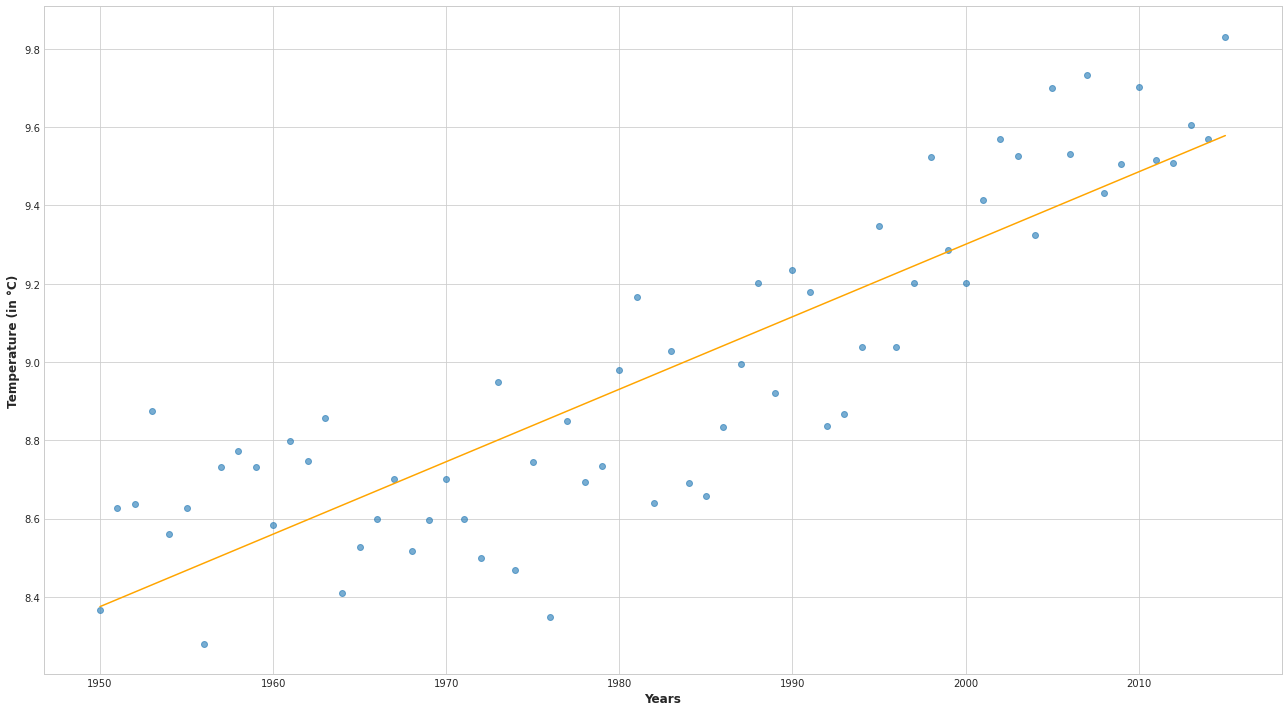

<Figure size 792x288 with 0 Axes>

In [31]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange")
plt.xlabel('Years')
plt.ylabel('Temperature (in °C)')
plt.show()
plt.clf()

In [32]:
print(lr.coef_)
print(lr.coef_ * 10)

[0.01851674]
[0.18516745]


In [33]:
print(lr.predict(np.array([2030, 2050]).reshape(-1,1)))

[ 9.85627013 10.22660503]


#### Interpretation

Every year, the average land temperature increases by an average of 0.0185 °C. Every ten years, the average land temperature increases by an average of 0.1852 °C.
The average land temperature in 2030 will be 9.856 °C and in 2050 10.227 °C.

# <a id="5">ARIMA model</a>


I'll take last 100 years to train a model

In [34]:
last100years = df['LandAverageTemperature'][200:]

### ADFuller test

In [35]:
adfuller(last100years)

(0.9908189487775706,
 0.9941681270229169,
 7,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 -26.232677281436082)

In [36]:
diff = last100years.diff().dropna()
adfuller(diff)

(-2.513163254136362,
 0.11230432501628679,
 9,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 -25.0875868431081)

### Autocorrelation

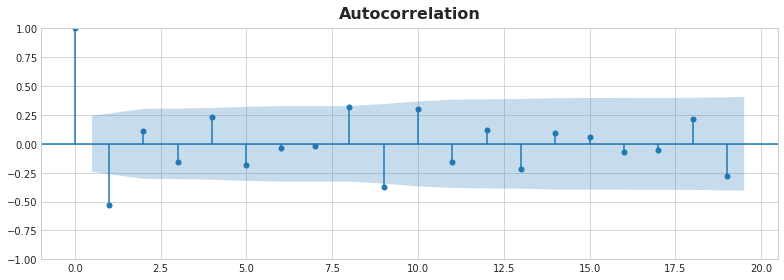

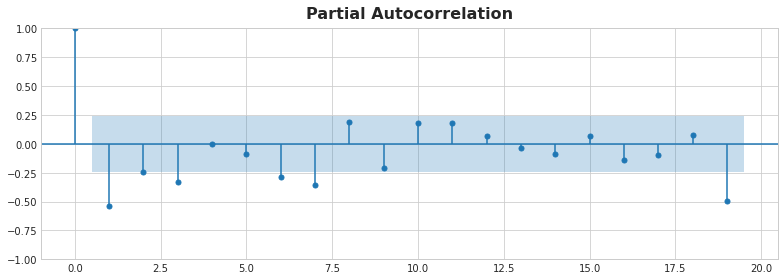

In [37]:
acf = plot_acf(diff)
pacf = plot_pacf(diff)

### Model

In [38]:
model = ARIMA(last100years, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     LandAverageTemperature   No. Observations:                   66
Model:                     ARIMA(1, 1, 1)   Log Likelihood                  13.669
Date:                    Thu, 10 Aug 2023   AIC                            -21.337
Time:                            06:12:47   BIC                            -14.814
Sample:                        12-31-1950   HQIC                           -18.764
                             - 12-31-2015                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1509      0.203     -0.743      0.457      -0.549       0.247
ma.L1         -0.6118      0.158     -3.869      0.000      -0.922      -0.302
sigma2         0.038

### Predictions

Text(0, 0.5, 'Land Average Temperature')

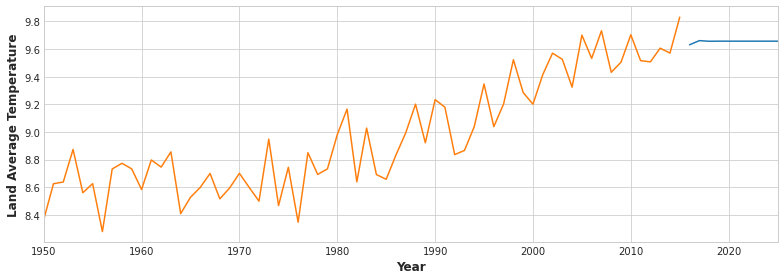

In [39]:
forecast = model_fit.forecast(10)
forecast.plot()
last100years.plot()
plt.xlabel('Year')
plt.ylabel('Land Average Temperature')